# Lecture 4 - Correlation functions 

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johannson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, coherent_dm, correlation_2op_2t, destroy, fock_dm,
                   mesolve, qeye, steadystate, tensor)

%matplotlib inline

## First-order coherence function


*Consider an oscillator that is interacting with a thermal environment.* If **the oscillator** <u>initially is in a coherent state</u>, it will *gradually decay to a thermal (incoherent) state*. **The amount of coherence can be quantified** <u>using the first-order optical coherence function</u>:

$$\displaystyle g^{(1)}(\tau) = \frac{\langle a^\dagger(\tau)a(0)\rangle}{\sqrt{\langle a^\dagger(\tau)a(\tau)\rangle\langle a^\dagger(0)a(0)\rangle}}$$


<u>For a coherent state $|g^{(1)}(\tau)| = 1$</u>, and <u>for a completely incoherent (thermal) state $g^{(1)}(\tau) = 0$</u>. 

The following code **calculates and plots $g^{(1)}(\tau)$ as a function of $\tau$**.

### Example: Decay of a coherent state to an incoherent (thermal) state

In [119]:
N = 20
taulist = np.linspace(0, 10.0, 200)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

# collapse operator
G1 = 0.75
n_th = 2.00  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = mesolve(H, rho0, taulist, c_ops, [a.dag() * a]).expect[0]   # ? mesolve(...).expect[0] means what
n = np.array(n)

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = correlation_2op_2t(H, rho0, None, taulist, c_ops, a.dag(), a)   # Is this the numeratore (upper term) of above func.?
                                                                     # AND, what are differences between 2nd argument, tlist
                                                                     # and 3rd argument, taulist?
# extract taulist results
if len(G1.shape) == 2:
    G1 = G1[0]

g1 = G1 / np.sqrt(n[0] * n)   # ? the same as the first order optical coherence func. describing the amount of coherence

c:\Users\13617\miniconda3\envs\qutip_env\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [120]:
len(G1.shape) == 2

False

>So why is a conditional sentence, "len(G1.shape) == 2" here? What is the purpose?

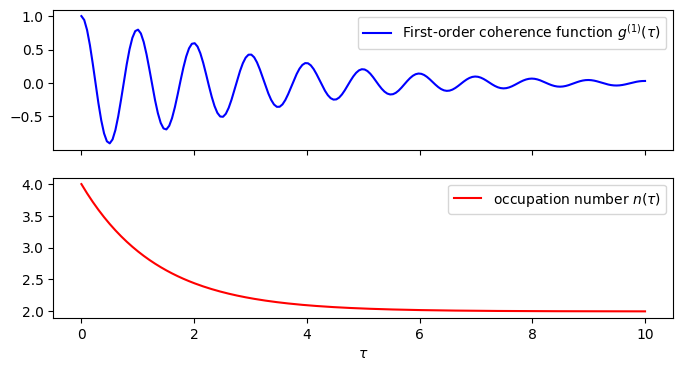

In [121]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(
    taulist, np.real(g1), "b",
    label=r"First-order coherence function $g^{(1)}(\tau)$"
)
axes[1].plot(taulist, np.real(n), "r", label=r"occupation number $n(\tau)$")
axes[0].legend()
axes[1].legend()
axes[1].set_xlabel(r"$\tau$");

## Second-order coherence function

$$\displaystyle g^{(2)}(\tau) = \frac{\langle a^\dagger(0)a^\dagger(\tau)a(\tau)a(0)\rangle}{\langle a^\dagger(0)a(0)\rangle^2}$$

<u>For a coherent state $|g^{(2)}(\tau)| = 1$</u>, and <u>for a thermal state $g^{(2)}(\tau) = 2$ (bunched photons, tend to appear together)</u>. 

The following code **calculates and plots $g^{(2)}(\tau)$ as a function of $\tau$**.

In [122]:
def correlation_ss_gtt(H, tlist, c_ops, a_op, b_op, c_op, d_op, rho0=None):  # a_op, b_op, c_op, d_op are (different) operators,
                                                                             # e.g., a_op is a, b_op is a.dag(), c_op is sm, d_op is sm.dag()
    """
    Calculate the correlation function <A(0)B(tau)C(tau)D(0)>

    (ss_gtt = steadystate general two-time)

    See, Gardiner, Quantum Noise, Section 5.2.1

    .. note::
        Experimental.
    """
    if rho0 is None:
        rho0 = steadystate(H, c_ops)
    
    return mesolve(H, d_op * rho0 * a_op, tlist, c_ops,
                   [b_op * c_op]).expect[0]

#### The role of steadystate(H, c_ops):
* Calculates the steady state for quantum evolution subject to the supplied Hamiltonian or Liouvillian operator and (if given a Hamiltonian) a list of collapse operators.

* If the user passes a Hamiltonian then it, along with the list of collapse operators, will be **converted into a Liouvillian operator in Lindblad form.**

In [123]:
# calculate the correlation function G2 and normalize with n to obtain g2
G2 = correlation_ss_gtt(H, taulist, c_ops, a.dag(), a.dag(), a, a, rho0=rho0)  # "a.dag(), a.dag(), a, a" seems the numerator of the 2nd-order coherence func.
                                                                               # But why? How it works?
g2 = G2 / n**2

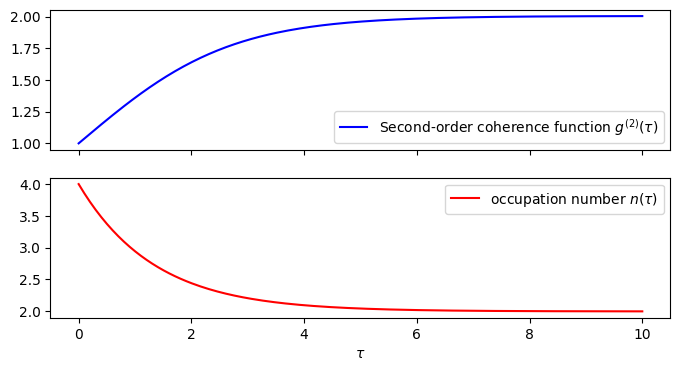

In [124]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

axes[0].plot(
    taulist, np.real(g2), "b",
    label=r"Second-order coherence function $g^{(2)}(\tau)$"
)
axes[1].plot(taulist, np.real(n), "r", label=r"occupation number $n(\tau)$")
axes[0].legend(loc=0)
axes[1].legend()
axes[1].set_xlabel(r"$\tau$");

## Leggett-Garg inequality

Definition: Given **an observable $Q(t)$** <u>that is bound below and above</u> *by $|Q(t)| \leq 1$*, <u>the assumptions of</u> 

 * <u>macroscopic realism</u>
 * <u>noninvasive measurements</u>

implies that

$$L(t_1, t_2) = \langle Q(t_1)Q(0)\rangle + \langle Q(t_1+t_2)Q(t_1)\rangle - \langle Q(t_1+t_2)Q(0)\rangle \leq 1$$
> This seems that there are 3 time points in total -- 0, t1, t1 + t2. <br>
> And this fucntion seems to descibe the amount of changes of Q(t) and compare the that of substeps and the whole process.<br>
> So, this is a constraint? for what?

*If $Q$ is at a steady state at the initial time of measurement*, we can *set $\tau = t_1 = t_2$* and **the Leggett-Garg inequality** then reads

$$
L(\tau) = 2\langle Q(\tau)Q(0)\rangle - \langle Q(2\tau)Q(0)\rangle \leq 1
$$

> ? Why is it: 
$$L(\tau) = \langle Q(\tau)Q(0)\rangle + \langle Q(2\tau)Q(\tau)\rangle - \langle Q(2\tau)Q(0)\rangle \leq 1$$

> so $2\langle Q(\tau)Q(0)\rangle = \langle Q(\tau)Q(0)\rangle + \langle Q(2\tau)Q(\tau)\rangle$ ?<br>
> but why?

### References

* [A. J. Leggett and A. Garg, Phys. Rev. Lett. 54, 857 (1985)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.54.857)
* [A. J. Leggett, J. Phys. Condens. Matter 14, R415 (2002)](http://dx.doi.org/10.1088/0953-8984/14/15/201)

In [125]:
def leggett_garg(c_mat):
    """
    For a given correlation matrix c_mat = <Q(t1+t2)Q(t1)>,
    calculate the Leggett-Garg correlation.
    """

    N, M = c_mat.shape

    lg_mat = np.zeros([N // 2, M // 2], dtype=complex)   # why "N // 2, M // 2"?
    lg_vec = np.zeros(N // 2, dtype=complex)

    # c_mat(i, j) = <Q(dt i+dt j)Q(dt i)>
    # LG = <Q(t_1)Q(0)> + <Q(t_1+t_2)Q(t_1)> - <Q(t_1+t_2)Q(0)>

    for i in range(N // 2):
        lg_vec[i] = 2 * c_mat[0, i] - c_mat[0, 2 * i]   # Is this LG = 2<Q(tau)Q(0)>  - <Q(2 * tau)Q(0)>? 

        for j in range(M // 2):
            lg_mat[i, j] = c_mat[0, i] + c_mat[i, j] - c_mat[0, i + j]   # ? seems exactly LG = <Q(t_1)Q(0)> + <Q(t_1+t_2)Q(t_1)> - <Q(t_1+t_2)Q(0)>

    return lg_mat, lg_vec

### Example: Leggett-Garg inequality <u>for two coupled resonators (optomechanical system)</u>


References:

 * [N. Lambert, J.R. Johansson, F. Nori, Phys. Rev. B 82, 245421 (2011)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.245421).

In [126]:
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # resonator frequency
g = 0.3 * 2 * np.pi  # coupling strength
kappa = 0.075  # cavity dissipation rate
gamma = 0.005  # resonator dissipation rate
Na = Nc = 3  # number of cavity fock states
n_th = 0.0  # avg number of thermal bath excitation

tlist = np.linspace(0, 7.5, 251)
tlist_sub = tlist[0:int((len(tlist) / 2))]

In [127]:
print(len(tlist) / 2)

125.5


> Why need tlist_sub here? What is the use of it?

In [ ]:
# start with an excited resonator
rho0 = tensor(fock_dm(Na, 0), fock_dm(Nc, 1))

a = tensor(qeye(Nc), destroy(Na))
c = tensor(destroy(Nc), qeye(Na))

na = a.dag() * a
nc = c.dag() * c

H = wa * na + wc * nc - g * (a + a.dag()) * (c + c.dag())   # The "classical" Hamiltonian, which have three terms: atom, cavity and coupling.

In [129]:
# measurement operator on resonator
Q = na  # photon number resolving detector
# fock-state |1> detector
# Q = tensor(qeye(Nc), 2 * fock_dm(Na, 1) - qeye(Na))
# click or no-click detector
# Q = tensor(qeye(Nc), qeye(Na) - 2 * fock_dm(Na, 0))

> So, here provides 3 types of detectors.<br>
> ? what are their differences

In [130]:
c_op_list = []

rate = kappa * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * c)   # ? add dissipation rate of cavity annihilation into c_op_list 

rate = kappa * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * c.dag())  # ? dissipation rate of cavity creation

rate = gamma * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a)   # ? dissipation rate of atom annihilation

rate = gamma * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a.dag())   # ? dissipation rate of atom creation

### Calculate the correlation function $\langle Q(t_1+t_2)Q(t_1)\rangle$

Using the regression theorem, and QuTiP function `correlation`.

In [131]:
corr_mat = correlation_2op_2t(H, rho0, tlist, tlist, c_op_list, Q, Q)   
# here, tlist = taulist;
# c_op_list is c_ops, containing c, c.dag(), a, a.dag() with their respectively 
# corresponding rates;
# "Q, Q" are a_op and b_op.

In [141]:
print(H)   # dims=[[3, 3], [3, 3]]
print("---")
print(rho0)   # dims=[[3, 3], [3, 3]]
print("---")

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dia, isherm=True
Qobj data =
[[ 0.          0.          0.          0.         -1.88495559  0.
   0.          0.          0.        ]
 [ 0.          6.28318531  0.         -1.88495559  0.         -2.66572976
   0.          0.          0.        ]
 [ 0.          0.         12.56637061  0.         -2.66572976  0.
   0.          0.          0.        ]
 [ 0.         -1.88495559  0.          6.28318531  0.          0.
   0.         -2.66572976  0.        ]
 [-1.88495559  0.         -2.66572976  0.         12.56637061  0.
  -2.66572976  0.         -3.76991118]
 [ 0.         -2.66572976  0.          0.          0.         18.84955592
   0.         -3.76991118  0.        ]
 [ 0.          0.          0.          0.         -2.66572976  0.
  12.56637061  0.          0.        ]
 [ 0.          0.          0.         -2.66572976  0.         -3.76991118
   0.         18.84955592  0.        ]
 [ 0.          0.          0.      

In [144]:
print(c_op_list)   # dims=[[3, 3], [3, 3]]

[Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0.         0.         0.         0.27386128 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.27386128 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.27386128
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.38729833 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.38729833 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.38729833]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]], Quantum object: dims=[[

In [143]:
print(Q)   # dims=[[3, 3], [3, 3]]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2.]]


### Calculate the Leggett-Garg correlation

In [132]:
LG_tt, LG_t = leggett_garg(corr_mat)

In [133]:
# print(LG_tt)

In [134]:
# print(LG_t)

### Plot results

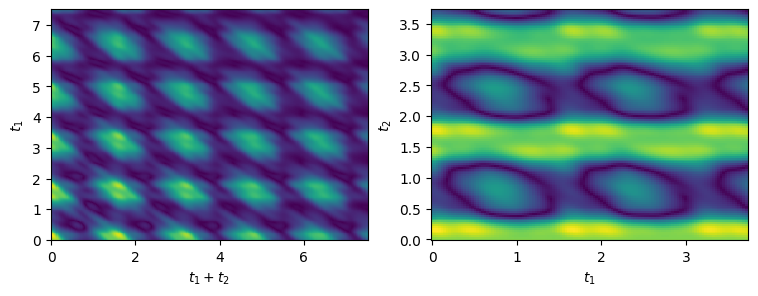

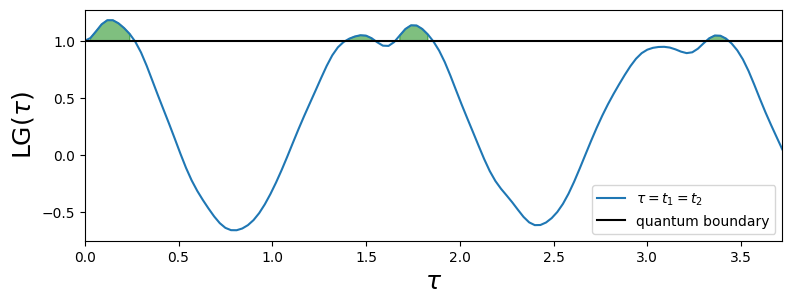

In [135]:
# 1st figure
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

axes[0].pcolor(tlist, tlist, abs(corr_mat), edgecolors="none")
axes[0].set_xlabel(r"$t_1 + t_2$")
axes[0].set_ylabel(r"$t_1$")
axes[0].autoscale(tight=True)

axes[1].pcolor(tlist_sub, tlist_sub, abs(LG_tt), edgecolors="none")   # Why tlist_sub? why abs(LG_tt)? Why not directly LG_tt?
axes[1].set_xlabel(r"$t_1$")
axes[1].set_ylabel(r"$t_2$")
axes[1].autoscale(tight=True)

# 2nd figure: LG(tau) vs tau
fig, axes = plt.subplots(1, 1, figsize=(9, 3))
axes.plot(tlist_sub, np.diag(np.real(LG_tt)), label=r"$\tau = t_1 = t_2$")   # Why need a diagonal array? And again, why only need real part?

# np.diag()
# Extract a diagonal or construct a diagonal array.

# np.real()
# Return the real part of the complex argument.

axes.plot(tlist_sub, np.ones(tlist_sub.shape), "k", label=r"quantum boundary")   # Why use np.ones(tlist_sub.shape)?
axes.fill_between(
    tlist_sub,
    np.diag(np.real(LG_tt)),
    1,
    where=(np.diag(np.real(LG_tt)) > 1),
    color="green",
    alpha=0.5,   # step length?
)
axes.set_xlim([0, max(tlist_sub)])
axes.legend(loc=0)
axes.set_xlabel(r"$\tau$", fontsize=18)
axes.set_ylabel(r"LG($\tau$)", fontsize=18);

 The reason for "Why abs(LG_tt)? Why not directly LG_tt?" about `axes[1].pcolor(tlist_sub, tlist_sub, abs(LG_tt), edgecolors="none")`
> It gives "TypeError: Image data of dtype complex128 cannot be converted to float"

In [136]:
np.ones(tlist_sub.shape)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

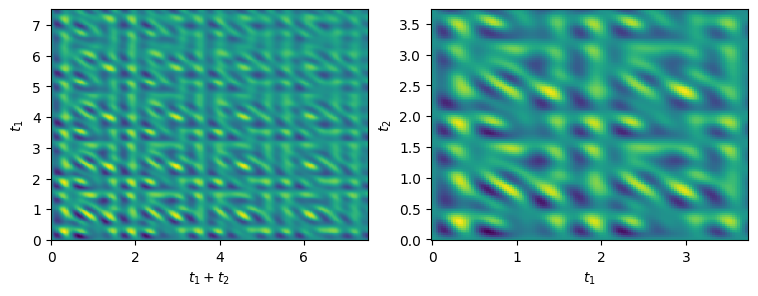

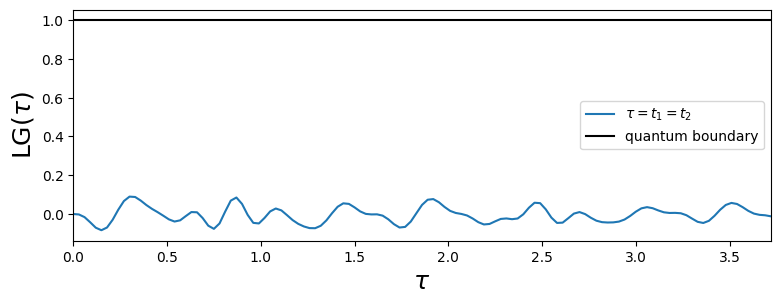

In [139]:
# 1st figure; but with np.imag(corr_mat) and np.imag(LG_tt)
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

axes[0].pcolor(tlist, tlist, np.imag(corr_mat), edgecolors="none")
axes[0].set_xlabel(r"$t_1 + t_2$")
axes[0].set_ylabel(r"$t_1$")
axes[0].autoscale(tight=True)

axes[1].pcolor(tlist_sub, tlist_sub, np.imag(LG_tt), edgecolors="none")   
axes[1].set_xlabel(r"$t_1$")
axes[1].set_ylabel(r"$t_2$")
axes[1].autoscale(tight=True)

# 2nd figure: LG(tau) vs tau; but with np.imag(corr_mat) and np.imag(LG_tt)
fig, axes = plt.subplots(1, 1, figsize=(9, 3))
axes.plot(tlist_sub, np.diag(np.imag(LG_tt)), label=r"$\tau = t_1 = t_2$")   # Why need a diagonal array? And again, why only need real part?

axes.plot(tlist_sub, np.ones(tlist_sub.shape), "k", label=r"quantum boundary")   # Why use np.ones(tlist_sub.shape)?
axes.fill_between(
    tlist_sub,
    np.diag(np.imag(LG_tt)),
    1,
    where=(np.diag(np.imag(LG_tt)) > 1),
    color="green",
    alpha=0.5,   # step length?
)
axes.set_xlim([0, max(tlist_sub)])
axes.legend(loc=0)
axes.set_xlabel(r"$\tau$", fontsize=18)
axes.set_ylabel(r"LG($\tau$)", fontsize=18);

> What are differences of using `np.real(corr_mat)`, `np.real(LG_tt)` ( or `abs(corr_mat)`, `abs(LG_tt)` ) compared with `np.imag(corr_mat)` ,`np.imag(LG_tt)` ?<br>
<br>
> Is the image generated by using `np.real(corr_mat)`, `np.real(LG_tt)` more pratically useful and more physcially reseach-interesting?
> It seems **yes**.<br>
> As shown in the *2nd figure: LG(tau) vs tau; but with np.imag(corr_mat) and np.imag(LG_tt)*, the LG($\tau$) is way too small and has no region above the quantum boundary.

### Generally,
This lecture seems to be mainly about phonons/bosons.

It discusses two functions (**1st order and 2nd order coherence functions**) reflecting the amount of coherence to indicate the circumstance of a state, whether the state is coherent or incoherent.<br>

Honestly, I dont fully understand the use of **Leggett-Garg inequality** currently. It seems a measurement technique, a correlation function, indicating ...?
Probably, the correlation bewtween two successive/adjacent time intervals/indexes to provide some info. about the time evolution of simulated sys. ?

### Software versions

In [138]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0
Numpy Version:      2.3.1
Scipy Version:      1.16.0
Cython Version:     3.1.2
Matplotlib Version: 3.10.3
Python Version:     3.13.5
Number of CPUs:     12
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\13617\miniconda3\envs\qutip_env\Lib\site-packages\qutip

Installed QuTiP family packages
-------------------------------

No QuTiP family packages installed.

Pl